# Average over multiple runs 

In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from baybe import Campaign
from baybe.objectives import SingleTargetObjective
from baybe.parameters import NumericalContinuousParameter
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget

# NOTE: simulate_scenarios does NOT take random_seed as argument
#       simulate_experiment does take random_seed as argument
# even though i tried to set random seed here, the results df's random seed always stays the same (from 1337 to 1346)
import random
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

from baybe.utils.random import set_random_seed
set_random_seed(42)

In [2]:
# Parameters for a full simulation loop
N_MC_ITERATIONS = 10             # # of repeats 
N_DOE_ITERATIONS = 25           # # of "budget"/rounds in each repeat
BOUNDS = torch.tensor([[-5., 0.], [10., 15.]])
DIMENSION = 2

In [3]:
def branin(x1, x2):
    y = float(
        (x2 - 5.1 / (4 * np.pi**2) * x1**2 + 5.0 / np.pi * x1 - 6.0) ** 2
        + 10 * (1 - 1.0 / (8 * np.pi)) * np.cos(x1)
        + 10
    )
    return y

WRAPPED_FUNCTION = branin

In [4]:
# create search space and objective
parameters = [
    NumericalContinuousParameter(
        name=f"x_{k+1}",
        bounds=(BOUNDS[0, k], BOUNDS[1, k]),
    )
    for k in range(DIMENSION)
]

searchspace = SearchSpace.from_product(parameters=parameters)
objective = SingleTargetObjective(target=NumericalTarget(name="Target", mode="MIN"))

In [5]:
# (define optimization strategy - recommender)
# construct campaign
campaign = Campaign(searchspace=searchspace, objective=objective)

In [6]:
# perform simulation loop
scenarios = {"Branin": campaign}
results = simulate_scenarios(
    scenarios,
    WRAPPED_FUNCTION,
    batch_size=1,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
    initial_data=None,
)

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\MF\anaconda3\envs\BayBE\lib\site-packages\botorch\models\transforms\outcome.py:289: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  stdvs = Y.std(dim=-2, keepdim=True)
c:\Users\MF\anaconda3\envs\BayBE\lib\site-packages\botorch\models\utils\assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
 10%|#         | 1/10 [00:07<01:06,  7.34s/it]c:\Users\MF\anaconda3\envs\BayBE\lib\site-packages\botorch\models\transforms\outcome.py:289: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel

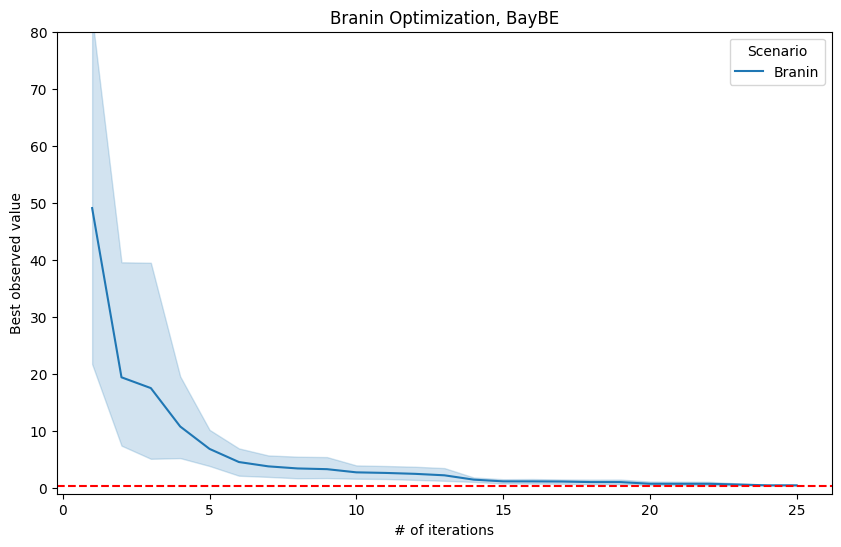

In [7]:
sns.lineplot(data=results, x="Num_Experiments", y="Target_CumBest", hue="Scenario")
plt.gcf().set_size_inches(10, 6)
plt.ylabel("Best observed value")
plt.xlabel("# of iterations")
plt.title("Branin Optimization, BayBE")
plt.ylim(-1, 80)
plt.axhline(0.397887, color="red", linestyle="--")

In [8]:
results

,Scenario,Random_Seed,Iteration,Num_Experiments,Target_Measurements,Target_IterBest,Target_CumBest
0,Branin,1337,0,1,[23.68487721017125],23.684877,23.684877
1,Branin,1337,1,2,[12.704745524424196],12.704746,12.704746
2,Branin,1337,2,3,[54.43140500747371],54.431405,12.704746
3,Branin,1337,3,4,[111.55210922486847],111.552109,12.704746
4,Branin,1337,4,5,[7.922871133042063],7.922871,7.922871
...,...,...,...,...,...,...,...
245,Branin,1346,20,21,[0.8291680479654495],0.829168,0.473423
246,Branin,1346,21,22,[2.0222418598540424],2.022242,0.473423
247,Branin,1346,22,23,[10.662034803318075],10.662035,0.473423
248,Branin,1346,23,24,[0.895451093955991],0.895451,0.473423


In [9]:
xx_baybe = results['Target_IterBest'].to_numpy()
reshape_baybe = xx_baybe.reshape(N_MC_ITERATIONS, N_DOE_ITERATIONS)
np.savetxt('xx-baybe.csv', reshape_baybe)